<a href="https://colab.research.google.com/github/aaronsouza/RDD-using-YOLOV11/blob/main/RDD_YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DOWNLOAD DATASET FROM ROBOFLOW
!pip install roboflow
from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
# Initialize Roboflow with your API key
rf = Roboflow(api_key="bCFryYsEHyQ3MJEGY9Ml")

In [3]:
# Load the new dataset
project = rf.workspace("owais-ahmad").project("road-damage-detection-and-classification-dataset")
version = project.version(1)  # Use the appropriate version number
dataset = version.download("yolov11")  # Download in YOLO format

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to road-damage-detection-and-classification-dataset-1 in yolov11:: 100%|██████████| 5670/5670 [00:00<00:00, 5973.39it/s]


In [4]:
# SHOW DATA SAMPLE
import cv2
import random
import glob as glob
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

# Define the YOLO bounding box conversion function
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

# Update class names for the new dataset
class_names = ['D00', 'D10', 'D20', 'D40']  # Replace with the actual class names from the dataset
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

# Function to plot bounding boxes on images
def plot_box(image, bboxes, labels):
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)

        class_name = class_names[int(labels[box_num])]

        # Draw bounding box
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        # Add class label
        font_scale = min(1, max(3, int(w / 500)))
        font_thickness = min(2, max(10, int(w / 50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin + 1, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

# Function to plot images with bounding boxes
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

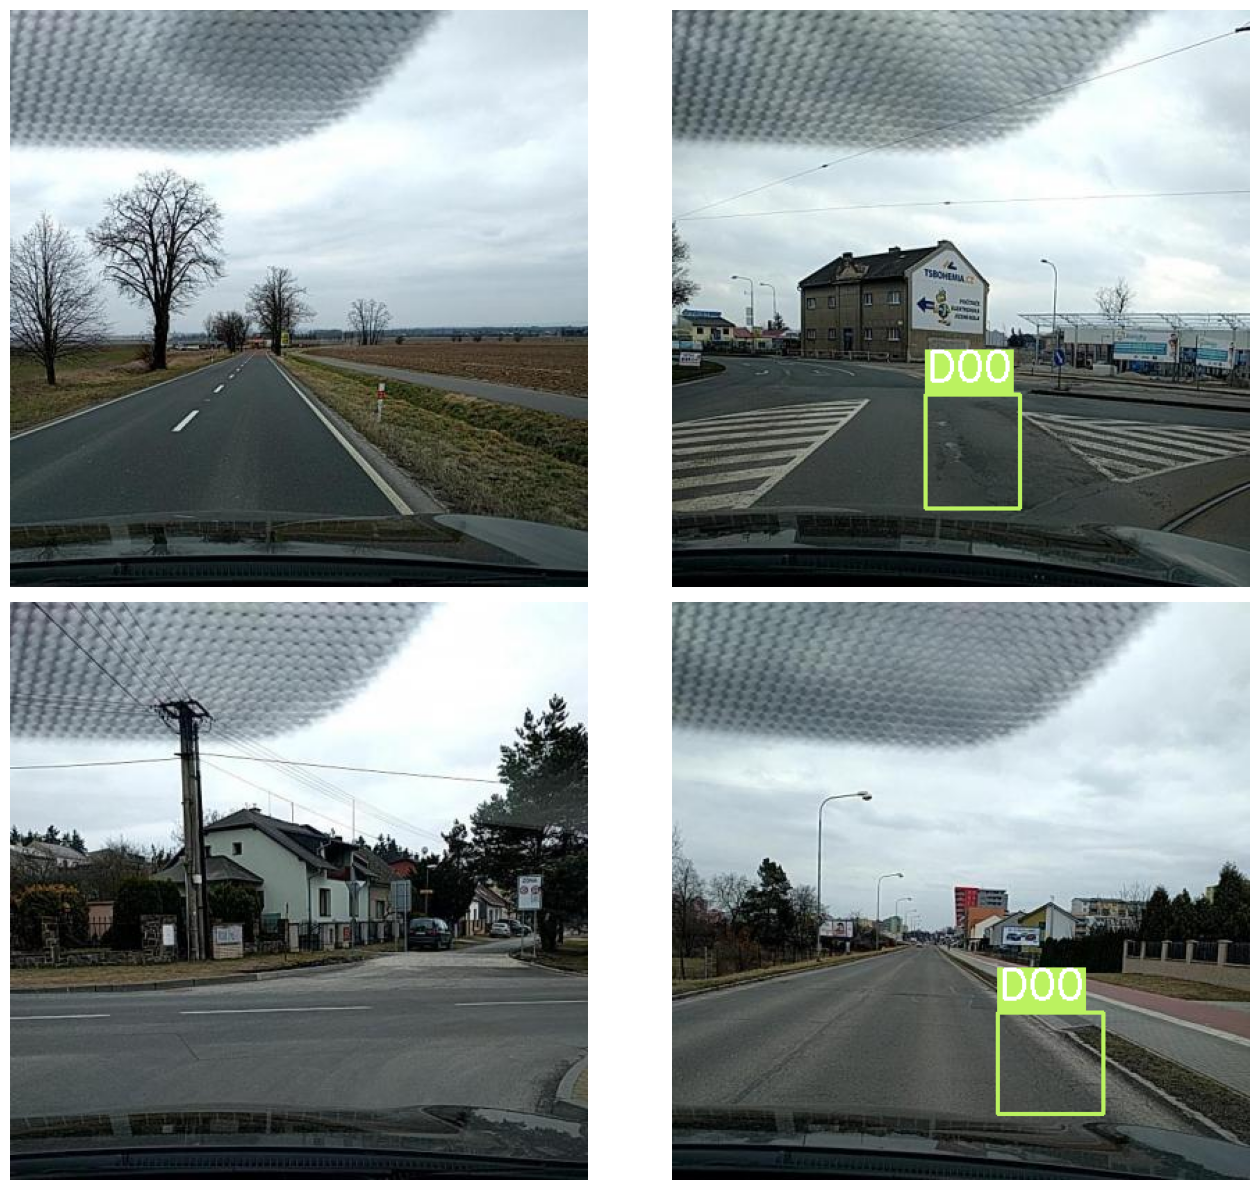

In [5]:
# Plot sample images
plot(
    image_paths=f'{dataset.location}/train/images/*',
    label_paths=f'{dataset.location}/train/labels/*',
    num_samples=4,
)

In [6]:
# APPLY YOLOv11
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [7]:
# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.0MB/s]


In [8]:
# Train the model on the new dataset
results = model.train(data=f"{dataset.location}/data.yaml", epochs=1)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/road-damage-detection-and-classification-dataset-1/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 57.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/road-damage-detection-and-classification-dataset-1/train/labels... 1980 images, 1219 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:01<00:00, 1046.99it/s]

train: New cache created: /content/road-damage-detection-and-classification-dataset-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/road-damage-detection-and-classification-dataset-1/valid/labels... 566 images, 350 backgrounds, 0 corrupt: 100%|██████████| 566/566 [00:00<00:00, 1066.72it/s]

val: New cache created: /content/road-damage-detection-and-classification-dataset-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      2.806      8.174      2.259         12        640: 100%|██████████| 124/124 [27:25<00:00, 13.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [03:07<00:00, 10.39s/it]


                   all        566        355      0.771    0.00641    0.00376    0.00098

1 epochs completed in 0.512 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [02:50<00:00,  9.46s/it]


                   all        566        355      0.771    0.00654    0.00377   0.000984
                   D00        156        195     0.0848     0.0261     0.0149     0.0039
                   D10         64         81          1          0   4.17e-05   4.17e-06
                   D20         25         33          1          0    0.00012   3.16e-05
                   D40         31         46          1          0          0          0
Speed: 7.6ms preprocess, 278.5ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/detect/train


In [9]:
# PREDICT ON NEW IMAGES
import cv2
import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Function to display predictions
def predict_and_plot(image_paths, num_samples=4):
    # Get all test images (you can change this to your test/validation set)
    all_test_images = glob.glob(f"{dataset.location}/test/images/*")
    all_test_images.sort()

    plt.figure(figsize=(15, 12))
    for i in range(min(num_samples, len(all_test_images))):
        # Run prediction
        results = model.predict(all_test_images[i], conf=0.5)  # confidence threshold

        # Plot the results
        for r in results:
            im_array = r.plot()  # plot a BGR numpy array of predictions
            im_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

            plt.subplot(2, 2, i + 1)
            plt.imshow(im_array)
            plt.axis('off')
            plt.title(f"Prediction {i+1}")

    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()



image 1/1 /content/road-damage-detection-and-classification-dataset-1/test/images/Czech_000030_jpg.rf.812ce78306b2b26b8dcf57060e080533.jpg: 640x640 (no detections), 226.9ms
Speed: 8.5ms preprocess, 226.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/road-damage-detection-and-classification-dataset-1/test/images/Czech_000047_jpg.rf.f7dc170df2203a06add76e3d53f4c627.jpg: 640x640 (no detections), 213.9ms
Speed: 4.1ms preprocess, 213.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/road-damage-detection-and-classification-dataset-1/test/images/Czech_000050_jpg.rf.c4ab28b998f616d5a224080988809e97.jpg: 640x640 (no detections), 228.6ms
Speed: 3.9ms preprocess, 228.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/road-damage-detection-and-classification-dataset-1/test/images/Czech_000066_jpg.rf.f2d5fbd958c89b4b550565e8f1fd59ad.jpg: 640x640 (no detections), 209.5ms
Speed: 4.3

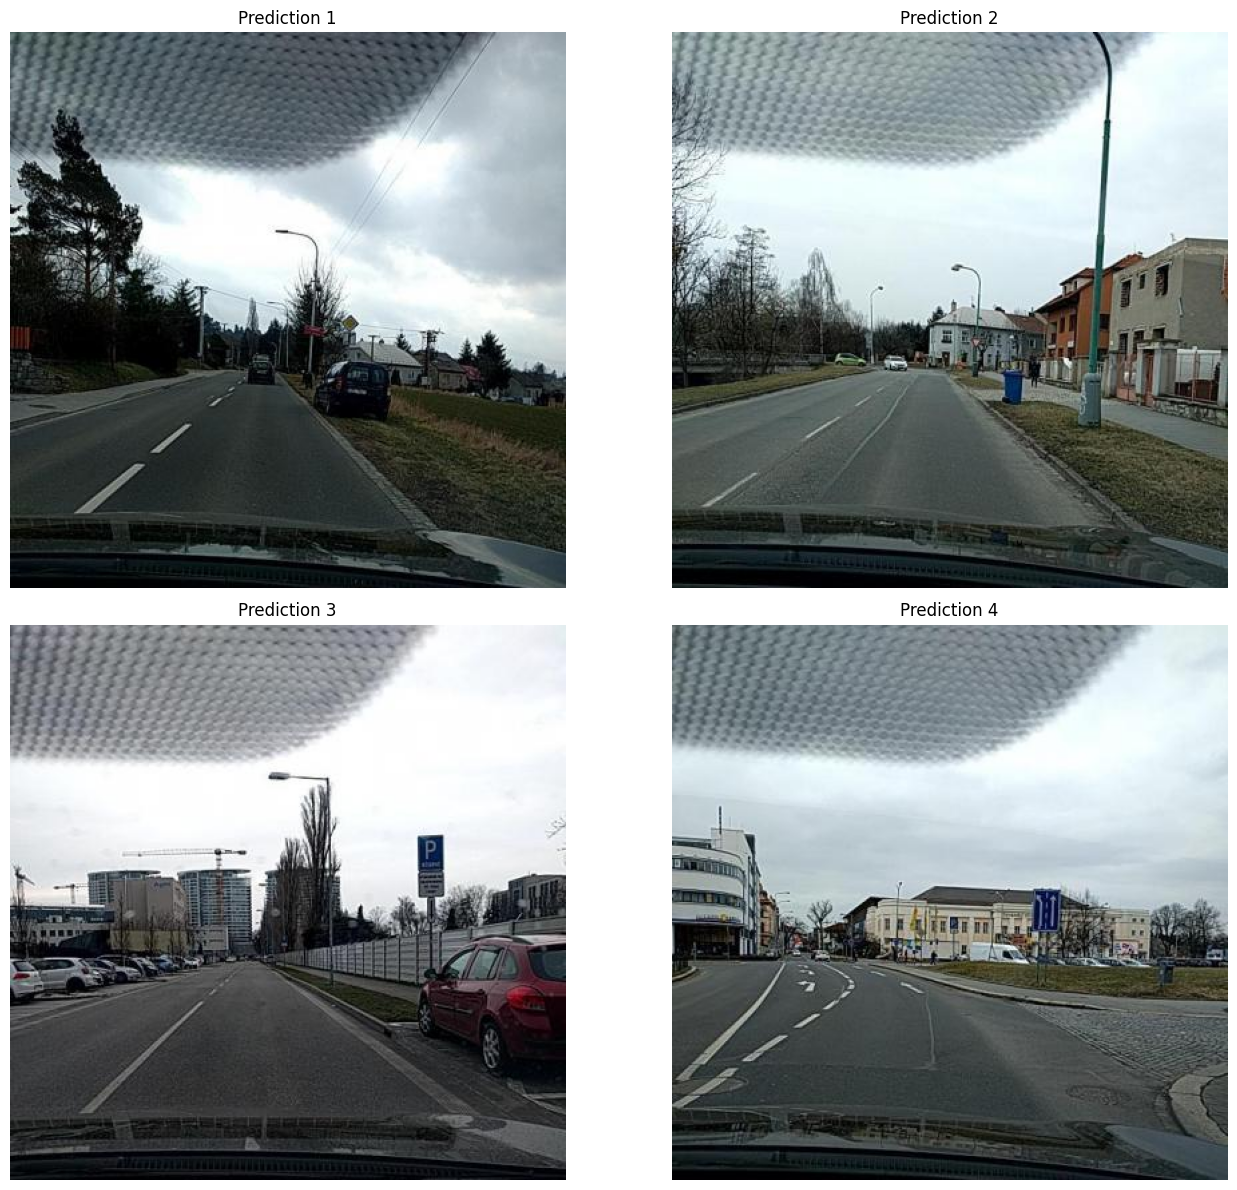

In [10]:
# Predict and plot sample images
predict_and_plot(f"{dataset.location}/test/images/*", num_samples=4)

# PREDICT ON A SINGLE IMAGE WITH MORE DETAILS
def predict_single_image(image_path, conf_threshold=0.5):
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run prediction
    results = model.predict(image_path, conf=conf_threshold)

    # Display original and predicted image
    plt.figure(figsize=(15, 8))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Predicted image
    for r in results:
        im_array = r.plot()
        im_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 2, 2)
        plt.imshow(im_array)
        plt.title("Predicted Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection details
    print("\nDetection Details:")
    for r in results:
        for box in r.boxes:
            print(f"Class: {class_names[int(box.cls)]}")
            print(f"Confidence: {box.conf.item():.2f}")
            print(f"Bounding Box Coordinates: {box.xyxy.tolist()[0]}\n")



image 1/1 /content/road-damage-detection-and-classification-dataset-1/test/images/Czech_000140_jpg.rf.0e4fe185ed3f04579ff8df91ad4313dd.jpg: 640x640 (no detections), 328.9ms
Speed: 7.9ms preprocess, 328.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


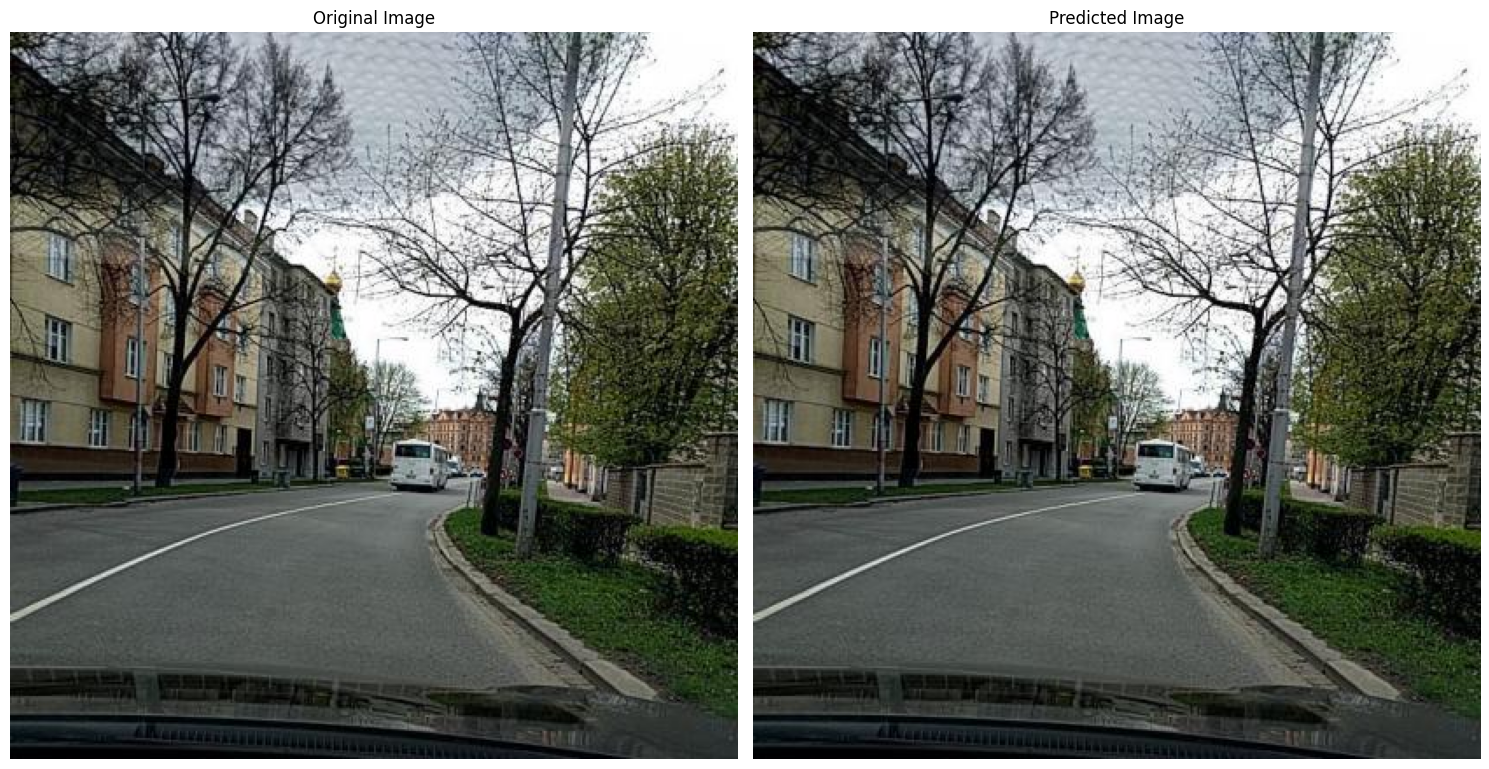


Detection Details:


In [11]:
# Example usage - predict on a single test image
test_images = glob.glob(f"{dataset.location}/test/images/*")
if test_images:
    predict_single_image(test_images[0])
